In [113]:
# !unzip 'fox_vs_dog.zip'

Prepare your own image dataset for binary classification with two classes: Fox v/s Dog. Use an appropriate neural network library (JAX or any other library) and a small CNN (not necessary to use big models like ResNet, or VGG if you do not have the compute power). Use an appropriate active learning algorithm from https://modal-python.readthedocs.io/en/latest/ library and show the active learning iterations v/s test accuracy curve. Explain your insights.

In [114]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

The Created Dataset has 463 images, 236 of dogs and 227 of foxes.

<a href = 'https://modal-python.readthedocs.io/en/latest/content/examples/Keras_integration.html'> Active Learning Model </a>

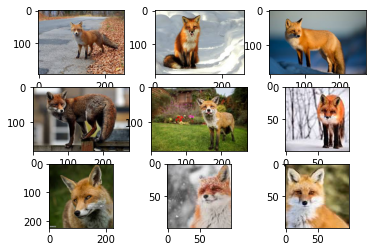

In [115]:
#Plotting some images of Fox
for i in range(9):
 plt.subplot(330 + 1 + i)
 # define filename
 folder = 'fox_vs_dog/'
 filename = folder+ 'fox/' +str(i) + '.jpg'
 # load image pixels
 image = imread(filename)
 # plot raw pixel data
 plt.imshow(image)
# show the figure
plt.show()

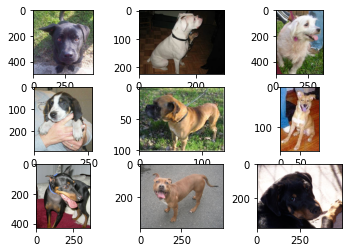

In [116]:
#Plotting some images of Dog
for i in range(9):
 plt.subplot(330 + 1 + i)
 # define filename
 folder = 'fox_vs_dog/'
 filename = folder+'dog/'+ str(i) + '.jpg'
 # load image pixels
 image = imread(filename)
 # plot raw pixel data
 plt.imshow(image)
# show the figure
plt.show()

In [117]:
!pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We will use a small CNN, whose summary we can see using the plot_model from keras.utils

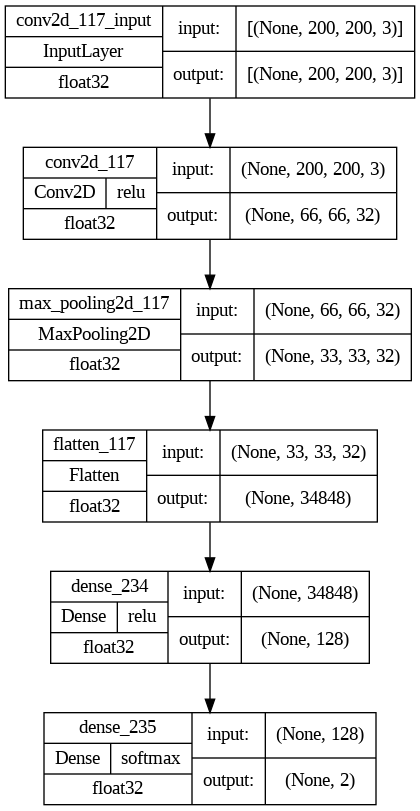

In [118]:
#Building the CNN
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, MaxPool2D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD, Adam
from keras.utils import plot_model

def keras_model():
  model = Sequential()
  model.add(Conv2D(32,3,3,input_shape=(200,200,3),activation='relu'))
  #step2-maxpooling
  model.add(MaxPooling2D(pool_size=(2,2)))
  #step3-flattening
  model.add(Flatten())
  #step4-fullconnection
  model.add(Dense(128,activation='relu'))
  model.add(Dense(2,activation='softmax'))
  opt = SGD(lr = 0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics = ['accuracy'])
  return model

show_summary = keras_model()
plot_model(
    show_summary,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations=True
)

We will use sklearn wrapper for adapting the keras model, and then use the classifier for Active Learning.

In [119]:
#using sklearn wrapper
classifier = KerasClassifier(keras_model)

<ipython-input-119-4f20f24f75e9>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifier = KerasClassifier(keras_model)


For image preprocessing, we have used ImageDataGenerator.

In [120]:
#Make all images of size 100x100 and split into training and validation
from keras.preprocessing.image import ImageDataGenerator
img_width = 200
img_height = 200

datagen = ImageDataGenerator(rescale=1/255.0, validation_split=0.15)

train_data_gen = datagen.flow_from_directory(directory='fox_vs_dog',
                                             target_size = (img_width, img_height),
                                             class_mode='binary',
                                             batch_size=16,
                                             subset='training')

vali_data_gen = datagen.flow_from_directory(directory='fox_vs_dog',
                                             target_size = (img_width, img_height),
                                             class_mode='binary',
                                             batch_size=16,
                                             subset='validation')

Found 394 images belonging to 2 classes.
Found 69 images belonging to 2 classes.


As the Active Learning Model which we use takes NumPy arrays as input, we will convert the data from ImageDataGenerator to Numpy Arrays.

In [121]:
#Convert data from ImageDataGenerator to numpy arrays
from keras.utils import to_categorical
x_train=np.concatenate([train_data_gen .next()[0] for i in range(train_data_gen .__len__())])
y_train=np.concatenate([train_data_gen .next()[1] for i in range(train_data_gen .__len__())])

x_val=np.concatenate([vali_data_gen .next()[0] for i in range(vali_data_gen .__len__())])
y_val=np.concatenate([vali_data_gen .next()[1] for i in range(vali_data_gen .__len__())])

y_train = to_categorical(y_train, 2)
y_val =to_categorical(y_val, 2)

In [122]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((394, 200, 200, 3), (394, 2), (69, 200, 200, 3), (69, 2))

Now, we will setup the initial training set.
Out of the 394 training images, we use 94 for initial training.

The rest 300 images go into the learning pool.

In [123]:
#Setup the initial training set for classifier
n_initial = 94
initial_idx = np.random.choice(range(len(x_train)), size=n_initial, replace=False)
X_initial = x_train[initial_idx]
y_initial = y_train[initial_idx]

# generate the pool
# remove the initial data from the training dataset
X_pool = np.delete(x_train, initial_idx, axis=0)[:5000]
y_pool = np.delete(y_train, initial_idx, axis=0)[:5000]

In [124]:
X_initial.shape, X_pool.shape

((94, 200, 200, 3), (300, 200, 200, 3))

In [125]:
!pip install modAL

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Initialising the ActiveLearner

In [126]:
from modAL.models import ActiveLearner

# initialize ActiveLearner
learner = ActiveLearner(
    estimator=classifier,
    X_training=X_initial, y_training=y_initial,
    verbose=1
)

3/3 [==============================] - 1s 136ms/step - loss: 0.6959 - accuracy: 0.5319


Active Learning Loop: We will do 15 queries, and in each query 20 images are taken from the learning pool.

In [127]:
n_queries = 15 #Number of Queries
accuracy_scores = [learner.score(x_val, y_val)] #Store accuracy Values

#Active Learning Loop
for idx in range(n_queries):
    print('Query no. %d' % (idx + 1))
    query_idx, query_instance = learner.query(X_pool, n_instances=20, verbose=0)
    learner.teach(
        X=X_pool[query_idx], y=y_pool[query_idx], only_new=True,
        verbose=2, epochs = 20
    )
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)
    accuracy_scores.append(learner.score(x_val, y_val))

3/3 [==============================] - 0s 24ms/step - loss: 0.6982 - accuracy: 0.5217
Query no. 1
Epoch 1/20


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 - 1s - loss: 0.6827 - accuracy: 0.7000 - 524ms/epoch - 524ms/step
Epoch 2/20
1/1 - 0s - loss: 0.6792 - accuracy: 0.7500 - 92ms/epoch - 92ms/step
Epoch 3/20
1/1 - 0s - loss: 0.6733 - accuracy: 0.8000 - 88ms/epoch - 88ms/step
Epoch 4/20
1/1 - 0s - loss: 0.6660 - accuracy: 0.7000 - 71ms/epoch - 71ms/step
Epoch 5/20
1/1 - 0s - loss: 0.6577 - accuracy: 0.6500 - 54ms/epoch - 54ms/step
Epoch 6/20
1/1 - 0s - loss: 0.6495 - accuracy: 0.6500 - 53ms/epoch - 53ms/step
Epoch 7/20
1/1 - 0s - loss: 0.6418 - accuracy: 0.6500 - 55ms/epoch - 55ms/step
Epoch 8/20
1/1 - 0s - loss: 0.6349 - accuracy: 0.6500 - 57ms/epoch - 57ms/step
Epoch 9/20
1/1 - 0s - loss: 0.6289 - accuracy: 0.6500 - 53ms/epoch - 53ms/step
Epoch 10/20
1/1 - 0s - loss: 0.6238 - accuracy: 0.6500 - 70ms/epoch - 70ms/step
Epoch 11/20
1/1 - 0s - loss: 0.6194 - accuracy: 0.6500 - 53ms/epoch - 53ms/step
Epoch 12/20
1/1 - 0s - loss: 0.6157 - accuracy: 0.6500 - 52ms/epoch - 52ms/step
Epoch 13/20
1/1 - 0s - loss: 0.6126 - accuracy: 0.6500 - 5

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 - 1s - loss: 0.6856 - accuracy: 0.5500 - 579ms/epoch - 579ms/step
Epoch 2/20
1/1 - 0s - loss: 0.6802 - accuracy: 0.6000 - 52ms/epoch - 52ms/step
Epoch 3/20
1/1 - 0s - loss: 0.6706 - accuracy: 0.6000 - 58ms/epoch - 58ms/step
Epoch 4/20
1/1 - 0s - loss: 0.6591 - accuracy: 0.6500 - 53ms/epoch - 53ms/step
Epoch 5/20
1/1 - 0s - loss: 0.6469 - accuracy: 0.6500 - 52ms/epoch - 52ms/step
Epoch 6/20
1/1 - 0s - loss: 0.6359 - accuracy: 0.6500 - 57ms/epoch - 57ms/step
Epoch 7/20
1/1 - 0s - loss: 0.6260 - accuracy: 0.6500 - 59ms/epoch - 59ms/step
Epoch 8/20
1/1 - 0s - loss: 0.6175 - accuracy: 0.6500 - 52ms/epoch - 52ms/step
Epoch 9/20
1/1 - 0s - loss: 0.6105 - accuracy: 0.6500 - 52ms/epoch - 52ms/step
Epoch 10/20
1/1 - 0s - loss: 0.6047 - accuracy: 0.6500 - 57ms/epoch - 57ms/step
Epoch 11/20
1/1 - 0s - loss: 0.6002 - accuracy: 0.6500 - 65ms/epoch - 65ms/step
Epoch 12/20
1/1 - 0s - loss: 0.5965 - accuracy: 0.6500 - 57ms/epoch - 57ms/step
Epoch 13/20
1/1 - 0s - loss: 0.5934 - accuracy: 0.6500 - 5

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 - 0s - loss: 0.6925 - accuracy: 0.4500 - 496ms/epoch - 496ms/step
Epoch 2/20
1/1 - 0s - loss: 0.6913 - accuracy: 0.4500 - 55ms/epoch - 55ms/step
Epoch 3/20
1/1 - 0s - loss: 0.6891 - accuracy: 0.4500 - 53ms/epoch - 53ms/step
Epoch 4/20
1/1 - 0s - loss: 0.6864 - accuracy: 0.4500 - 54ms/epoch - 54ms/step
Epoch 5/20
1/1 - 0s - loss: 0.6834 - accuracy: 0.5000 - 105ms/epoch - 105ms/step
Epoch 6/20
1/1 - 0s - loss: 0.6804 - accuracy: 0.5500 - 96ms/epoch - 96ms/step
Epoch 7/20
1/1 - 0s - loss: 0.6777 - accuracy: 0.7000 - 91ms/epoch - 91ms/step
Epoch 8/20
1/1 - 0s - loss: 0.6753 - accuracy: 0.7500 - 93ms/epoch - 93ms/step
Epoch 9/20
1/1 - 0s - loss: 0.6728 - accuracy: 0.9000 - 85ms/epoch - 85ms/step
Epoch 10/20
1/1 - 0s - loss: 0.6703 - accuracy: 0.8000 - 86ms/epoch - 86ms/step
Epoch 11/20
1/1 - 0s - loss: 0.6675 - accuracy: 0.8000 - 113ms/epoch - 113ms/step
Epoch 12/20
1/1 - 0s - loss: 0.6647 - accuracy: 0.7500 - 90ms/epoch - 90ms/step
Epoch 13/20
1/1 - 0s - loss: 0.6616 - accuracy: 0.7000

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
1/1 - 3s - loss: 0.6718 - accuracy: 0.5500 - 3s/epoch - 3s/step
Epoch 2/20
1/1 - 0s - loss: 0.6678 - accuracy: 0.5500 - 94ms/epoch - 94ms/step
Epoch 3/20
1/1 - 0s - loss: 0.6619 - accuracy: 0.5500 - 122ms/epoch - 122ms/step
Epoch 4/20
1/1 - 0s - loss: 0.6546 - accuracy: 0.5500 - 95ms/epoch - 95ms/step
Epoch 5/20
1/1 - 0s - loss: 0.6461 - accuracy: 0.5500 - 131ms/epoch - 131ms/step
Epoch 6/20
1/1 - 0s - loss: 0.6371 - accuracy: 0.5500 - 95ms/epoch - 95ms/step
Epoch 7/20
1/1 - 0s - loss: 0.6274 - accuracy: 0.5500 - 87ms/epoch - 87ms/step
Epoch 8/20
1/1 - 0s - loss: 0.6174 - accuracy: 0.6000 - 107ms/epoch - 107ms/step
Epoch 9/20
1/1 - 0s - loss: 0.6068 - accuracy: 0.6500 - 121ms/epoch - 121ms/step
Epoch 10/20
1/1 - 0s - loss: 0.5957 - accuracy: 0.7000 - 100ms/epoch - 100ms/step
Epoch 11/20
1/1 - 0s - loss: 0.5851 - accuracy: 0.7500 - 91ms/epoch - 91ms/step
Epoch 12/20
1/1 - 0s - loss: 0.5743 - accuracy: 0.8000 - 108ms/epoch - 108ms/step
Epoch 13/20
1/1 - 0s - loss: 0.5635 - acc

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 - 1s - loss: 0.7058 - accuracy: 0.4500 - 1s/epoch - 1s/step
Epoch 2/20
1/1 - 0s - loss: 0.6969 - accuracy: 0.4500 - 95ms/epoch - 95ms/step
Epoch 3/20
1/1 - 0s - loss: 0.6836 - accuracy: 0.7000 - 96ms/epoch - 96ms/step
Epoch 4/20
1/1 - 0s - loss: 0.6715 - accuracy: 0.5500 - 80ms/epoch - 80ms/step
Epoch 5/20
1/1 - 0s - loss: 0.6644 - accuracy: 0.5500 - 88ms/epoch - 88ms/step
Epoch 6/20
1/1 - 0s - loss: 0.6620 - accuracy: 0.5500 - 77ms/epoch - 77ms/step
Epoch 7/20
1/1 - 0s - loss: 0.6620 - accuracy: 0.5500 - 87ms/epoch - 87ms/step
Epoch 8/20
1/1 - 0s - loss: 0.6605 - accuracy: 0.5500 - 84ms/epoch - 84ms/step
Epoch 9/20
1/1 - 0s - loss: 0.6564 - accuracy: 0.5500 - 99ms/epoch - 99ms/step
Epoch 10/20
1/1 - 0s - loss: 0.6499 - accuracy: 0.5500 - 104ms/epoch - 104ms/step
Epoch 11/20
1/1 - 0s - loss: 0.6419 - accuracy: 0.5500 - 95ms/epoch - 95ms/step
Epoch 12/20
1/1 - 0s - loss: 0.6343 - accuracy: 0.5500 - 110ms/epoch - 110ms/step
Epoch 13/20
1/1 - 0s - loss: 0.6281 - accuracy: 0.5500 - 117

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
1/1 - 3s - loss: 0.7037 - accuracy: 0.3500 - 3s/epoch - 3s/step
Epoch 2/20
1/1 - 0s - loss: 0.6777 - accuracy: 0.7000 - 101ms/epoch - 101ms/step
Epoch 3/20
1/1 - 0s - loss: 0.6432 - accuracy: 0.7500 - 107ms/epoch - 107ms/step
Epoch 4/20
1/1 - 0s - loss: 0.6174 - accuracy: 0.7500 - 101ms/epoch - 101ms/step
Epoch 5/20
1/1 - 0s - loss: 0.6025 - accuracy: 0.7500 - 95ms/epoch - 95ms/step
Epoch 6/20
1/1 - 0s - loss: 0.5966 - accuracy: 0.7500 - 73ms/epoch - 73ms/step
Epoch 7/20
1/1 - 0s - loss: 0.5949 - accuracy: 0.7500 - 68ms/epoch - 68ms/step
Epoch 8/20
1/1 - 0s - loss: 0.5933 - accuracy: 0.7500 - 62ms/epoch - 62ms/step
Epoch 9/20
1/1 - 0s - loss: 0.5899 - accuracy: 0.7500 - 53ms/epoch - 53ms/step
Epoch 10/20
1/1 - 0s - loss: 0.5822 - accuracy: 0.7500 - 57ms/epoch - 57ms/step
Epoch 11/20
1/1 - 0s - loss: 0.5705 - accuracy: 0.7500 - 53ms/epoch - 53ms/step
Epoch 12/20
1/1 - 0s - loss: 0.5574 - accuracy: 0.7500 - 56ms/epoch - 56ms/step
Epoch 13/20
1/1 - 0s - loss: 0.5442 - accuracy:

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 - 0s - loss: 0.6924 - accuracy: 0.6000 - 480ms/epoch - 480ms/step
Epoch 2/20
1/1 - 0s - loss: 0.6902 - accuracy: 0.6500 - 53ms/epoch - 53ms/step
Epoch 3/20
1/1 - 0s - loss: 0.6865 - accuracy: 0.6000 - 64ms/epoch - 64ms/step
Epoch 4/20
1/1 - 0s - loss: 0.6822 - accuracy: 0.5500 - 56ms/epoch - 56ms/step
Epoch 5/20
1/1 - 0s - loss: 0.6778 - accuracy: 0.5500 - 57ms/epoch - 57ms/step
Epoch 6/20
1/1 - 0s - loss: 0.6736 - accuracy: 0.5500 - 53ms/epoch - 53ms/step
Epoch 7/20
1/1 - 0s - loss: 0.6701 - accuracy: 0.5500 - 58ms/epoch - 58ms/step
Epoch 8/20
1/1 - 0s - loss: 0.6668 - accuracy: 0.5500 - 56ms/epoch - 56ms/step
Epoch 9/20
1/1 - 0s - loss: 0.6634 - accuracy: 0.5500 - 52ms/epoch - 52ms/step
Epoch 10/20
1/1 - 0s - loss: 0.6597 - accuracy: 0.5500 - 55ms/epoch - 55ms/step
Epoch 11/20
1/1 - 0s - loss: 0.6556 - accuracy: 0.5500 - 56ms/epoch - 56ms/step
Epoch 12/20
1/1 - 0s - loss: 0.6513 - accuracy: 0.5500 - 54ms/epoch - 54ms/step
Epoch 13/20
1/1 - 0s - loss: 0.6467 - accuracy: 0.5500 - 5

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 - 1s - loss: 0.7064 - accuracy: 0.5500 - 519ms/epoch - 519ms/step
Epoch 2/20
1/1 - 0s - loss: 0.7034 - accuracy: 0.5500 - 54ms/epoch - 54ms/step
Epoch 3/20
1/1 - 0s - loss: 0.6985 - accuracy: 0.5500 - 52ms/epoch - 52ms/step
Epoch 4/20
1/1 - 0s - loss: 0.6926 - accuracy: 0.5500 - 52ms/epoch - 52ms/step
Epoch 5/20
1/1 - 0s - loss: 0.6865 - accuracy: 0.5500 - 59ms/epoch - 59ms/step
Epoch 6/20
1/1 - 0s - loss: 0.6811 - accuracy: 0.5500 - 57ms/epoch - 57ms/step
Epoch 7/20
1/1 - 0s - loss: 0.6765 - accuracy: 0.5500 - 56ms/epoch - 56ms/step
Epoch 8/20
1/1 - 0s - loss: 0.6726 - accuracy: 0.5500 - 53ms/epoch - 53ms/step
Epoch 9/20
1/1 - 0s - loss: 0.6690 - accuracy: 0.5500 - 54ms/epoch - 54ms/step
Epoch 10/20
1/1 - 0s - loss: 0.6656 - accuracy: 0.5500 - 54ms/epoch - 54ms/step
Epoch 11/20
1/1 - 0s - loss: 0.6624 - accuracy: 0.5500 - 57ms/epoch - 57ms/step
Epoch 12/20
1/1 - 0s - loss: 0.6592 - accuracy: 0.5500 - 54ms/epoch - 54ms/step
Epoch 13/20
1/1 - 0s - loss: 0.6556 - accuracy: 0.5500 - 6

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 - 0s - loss: 0.7020 - accuracy: 0.4000 - 489ms/epoch - 489ms/step
Epoch 2/20
1/1 - 0s - loss: 0.6974 - accuracy: 0.5000 - 50ms/epoch - 50ms/step
Epoch 3/20
1/1 - 0s - loss: 0.6895 - accuracy: 0.6000 - 55ms/epoch - 55ms/step
Epoch 4/20
1/1 - 0s - loss: 0.6798 - accuracy: 0.6500 - 52ms/epoch - 52ms/step
Epoch 5/20
1/1 - 0s - loss: 0.6701 - accuracy: 0.6500 - 53ms/epoch - 53ms/step
Epoch 6/20
1/1 - 0s - loss: 0.6617 - accuracy: 0.6500 - 55ms/epoch - 55ms/step
Epoch 7/20
1/1 - 0s - loss: 0.6547 - accuracy: 0.6500 - 64ms/epoch - 64ms/step
Epoch 8/20
1/1 - 0s - loss: 0.6499 - accuracy: 0.6500 - 60ms/epoch - 60ms/step
Epoch 9/20
1/1 - 0s - loss: 0.6463 - accuracy: 0.6500 - 56ms/epoch - 56ms/step
Epoch 10/20
1/1 - 0s - loss: 0.6429 - accuracy: 0.6500 - 71ms/epoch - 71ms/step
Epoch 11/20
1/1 - 0s - loss: 0.6391 - accuracy: 0.6500 - 55ms/epoch - 55ms/step
Epoch 12/20
1/1 - 0s - loss: 0.6353 - accuracy: 0.6500 - 55ms/epoch - 55ms/step
Epoch 13/20
1/1 - 0s - loss: 0.6310 - accuracy: 0.6500 - 5

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 - 0s - loss: 0.7290 - accuracy: 0.3500 - 473ms/epoch - 473ms/step
Epoch 2/20
1/1 - 0s - loss: 0.7176 - accuracy: 0.3500 - 88ms/epoch - 88ms/step
Epoch 3/20
1/1 - 0s - loss: 0.6987 - accuracy: 0.4500 - 87ms/epoch - 87ms/step
Epoch 4/20
1/1 - 0s - loss: 0.6774 - accuracy: 0.6500 - 87ms/epoch - 87ms/step
Epoch 5/20
1/1 - 0s - loss: 0.6600 - accuracy: 0.6500 - 93ms/epoch - 93ms/step
Epoch 6/20
1/1 - 0s - loss: 0.6462 - accuracy: 0.6500 - 95ms/epoch - 95ms/step
Epoch 7/20
1/1 - 0s - loss: 0.6365 - accuracy: 0.6500 - 93ms/epoch - 93ms/step
Epoch 8/20
1/1 - 0s - loss: 0.6305 - accuracy: 0.6500 - 87ms/epoch - 87ms/step
Epoch 9/20
1/1 - 0s - loss: 0.6260 - accuracy: 0.6500 - 90ms/epoch - 90ms/step
Epoch 10/20
1/1 - 0s - loss: 0.6236 - accuracy: 0.6500 - 87ms/epoch - 87ms/step
Epoch 11/20
1/1 - 0s - loss: 0.6228 - accuracy: 0.6500 - 92ms/epoch - 92ms/step
Epoch 12/20
1/1 - 0s - loss: 0.6221 - accuracy: 0.6500 - 89ms/epoch - 89ms/step
Epoch 13/20
1/1 - 0s - loss: 0.6209 - accuracy: 0.6500 - 9

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 - 0s - loss: 0.7068 - accuracy: 0.4500 - 495ms/epoch - 495ms/step
Epoch 2/20
1/1 - 0s - loss: 0.7017 - accuracy: 0.5000 - 59ms/epoch - 59ms/step
Epoch 3/20
1/1 - 0s - loss: 0.6934 - accuracy: 0.5000 - 57ms/epoch - 57ms/step
Epoch 4/20
1/1 - 0s - loss: 0.6844 - accuracy: 0.6000 - 62ms/epoch - 62ms/step
Epoch 5/20
1/1 - 0s - loss: 0.6757 - accuracy: 0.6000 - 61ms/epoch - 61ms/step
Epoch 6/20
1/1 - 0s - loss: 0.6684 - accuracy: 0.6000 - 55ms/epoch - 55ms/step
Epoch 7/20
1/1 - 0s - loss: 0.6623 - accuracy: 0.6000 - 55ms/epoch - 55ms/step
Epoch 8/20
1/1 - 0s - loss: 0.6569 - accuracy: 0.6000 - 54ms/epoch - 54ms/step
Epoch 9/20
1/1 - 0s - loss: 0.6516 - accuracy: 0.6500 - 57ms/epoch - 57ms/step
Epoch 10/20
1/1 - 0s - loss: 0.6456 - accuracy: 0.6500 - 56ms/epoch - 56ms/step
Epoch 11/20
1/1 - 0s - loss: 0.6390 - accuracy: 0.6500 - 54ms/epoch - 54ms/step
Epoch 12/20
1/1 - 0s - loss: 0.6316 - accuracy: 0.6500 - 55ms/epoch - 55ms/step
Epoch 13/20
1/1 - 0s - loss: 0.6240 - accuracy: 0.6500 - 5

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 - 0s - loss: 0.6948 - accuracy: 0.5500 - 472ms/epoch - 472ms/step
Epoch 2/20
1/1 - 0s - loss: 0.6926 - accuracy: 0.5500 - 54ms/epoch - 54ms/step
Epoch 3/20
1/1 - 0s - loss: 0.6892 - accuracy: 0.5500 - 54ms/epoch - 54ms/step
Epoch 4/20
1/1 - 0s - loss: 0.6857 - accuracy: 0.5500 - 54ms/epoch - 54ms/step
Epoch 5/20
1/1 - 0s - loss: 0.6819 - accuracy: 0.5500 - 54ms/epoch - 54ms/step
Epoch 6/20
1/1 - 0s - loss: 0.6781 - accuracy: 0.5500 - 55ms/epoch - 55ms/step
Epoch 7/20
1/1 - 0s - loss: 0.6743 - accuracy: 0.5500 - 60ms/epoch - 60ms/step
Epoch 8/20
1/1 - 0s - loss: 0.6701 - accuracy: 0.5500 - 55ms/epoch - 55ms/step
Epoch 9/20
1/1 - 0s - loss: 0.6658 - accuracy: 0.5500 - 54ms/epoch - 54ms/step
Epoch 10/20
1/1 - 0s - loss: 0.6613 - accuracy: 0.5500 - 56ms/epoch - 56ms/step
Epoch 11/20
1/1 - 0s - loss: 0.6567 - accuracy: 0.6500 - 54ms/epoch - 54ms/step
Epoch 12/20
1/1 - 0s - loss: 0.6517 - accuracy: 0.6500 - 54ms/epoch - 54ms/step
Epoch 13/20
1/1 - 0s - loss: 0.6462 - accuracy: 0.6500 - 5

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 - 0s - loss: 0.7253 - accuracy: 0.5000 - 488ms/epoch - 488ms/step
Epoch 2/20
1/1 - 0s - loss: 0.7189 - accuracy: 0.5000 - 55ms/epoch - 55ms/step
Epoch 3/20
1/1 - 0s - loss: 0.7088 - accuracy: 0.5000 - 58ms/epoch - 58ms/step
Epoch 4/20
1/1 - 0s - loss: 0.6987 - accuracy: 0.5000 - 54ms/epoch - 54ms/step
Epoch 5/20
1/1 - 0s - loss: 0.6903 - accuracy: 0.5000 - 52ms/epoch - 52ms/step
Epoch 6/20
1/1 - 0s - loss: 0.6840 - accuracy: 0.7000 - 53ms/epoch - 53ms/step
Epoch 7/20
1/1 - 0s - loss: 0.6814 - accuracy: 0.5500 - 53ms/epoch - 53ms/step
Epoch 8/20
1/1 - 0s - loss: 0.6799 - accuracy: 0.5000 - 55ms/epoch - 55ms/step
Epoch 9/20
1/1 - 0s - loss: 0.6785 - accuracy: 0.5000 - 55ms/epoch - 55ms/step
Epoch 10/20
1/1 - 0s - loss: 0.6762 - accuracy: 0.5000 - 55ms/epoch - 55ms/step
Epoch 11/20
1/1 - 0s - loss: 0.6731 - accuracy: 0.5000 - 54ms/epoch - 54ms/step
Epoch 12/20
1/1 - 0s - loss: 0.6692 - accuracy: 0.5000 - 57ms/epoch - 57ms/step
Epoch 13/20
1/1 - 0s - loss: 0.6650 - accuracy: 0.5000 - 6

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 - 0s - loss: 0.7028 - accuracy: 0.5000 - 491ms/epoch - 491ms/step
Epoch 2/20
1/1 - 0s - loss: 0.7011 - accuracy: 0.5000 - 54ms/epoch - 54ms/step
Epoch 3/20
1/1 - 0s - loss: 0.6979 - accuracy: 0.5000 - 53ms/epoch - 53ms/step
Epoch 4/20
1/1 - 0s - loss: 0.6939 - accuracy: 0.5000 - 53ms/epoch - 53ms/step
Epoch 5/20
1/1 - 0s - loss: 0.6897 - accuracy: 0.5000 - 56ms/epoch - 56ms/step
Epoch 6/20
1/1 - 0s - loss: 0.6858 - accuracy: 0.5500 - 56ms/epoch - 56ms/step
Epoch 7/20
1/1 - 0s - loss: 0.6826 - accuracy: 0.6500 - 57ms/epoch - 57ms/step
Epoch 8/20
1/1 - 0s - loss: 0.6799 - accuracy: 0.7000 - 59ms/epoch - 59ms/step
Epoch 9/20
1/1 - 0s - loss: 0.6771 - accuracy: 0.7500 - 58ms/epoch - 58ms/step
Epoch 10/20
1/1 - 0s - loss: 0.6743 - accuracy: 0.8000 - 53ms/epoch - 53ms/step
Epoch 11/20
1/1 - 0s - loss: 0.6714 - accuracy: 0.8500 - 54ms/epoch - 54ms/step
Epoch 12/20
1/1 - 0s - loss: 0.6686 - accuracy: 0.8500 - 55ms/epoch - 55ms/step
Epoch 13/20
1/1 - 0s - loss: 0.6659 - accuracy: 0.8500 - 6

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 - 0s - loss: 0.7401 - accuracy: 0.3500 - 461ms/epoch - 461ms/step
Epoch 2/20
1/1 - 0s - loss: 0.7144 - accuracy: 0.3500 - 55ms/epoch - 55ms/step
Epoch 3/20
1/1 - 0s - loss: 0.6806 - accuracy: 0.7500 - 79ms/epoch - 79ms/step
Epoch 4/20
1/1 - 0s - loss: 0.6598 - accuracy: 0.6500 - 80ms/epoch - 80ms/step
Epoch 5/20
1/1 - 0s - loss: 0.6565 - accuracy: 0.6500 - 80ms/epoch - 80ms/step
Epoch 6/20
1/1 - 0s - loss: 0.6631 - accuracy: 0.6500 - 89ms/epoch - 89ms/step
Epoch 7/20
1/1 - 0s - loss: 0.6698 - accuracy: 0.6500 - 92ms/epoch - 92ms/step
Epoch 8/20
1/1 - 0s - loss: 0.6690 - accuracy: 0.6500 - 91ms/epoch - 91ms/step
Epoch 9/20
1/1 - 0s - loss: 0.6605 - accuracy: 0.6500 - 87ms/epoch - 87ms/step
Epoch 10/20
1/1 - 0s - loss: 0.6479 - accuracy: 0.6500 - 92ms/epoch - 92ms/step
Epoch 11/20
1/1 - 0s - loss: 0.6353 - accuracy: 0.6500 - 91ms/epoch - 91ms/step
Epoch 12/20
1/1 - 0s - loss: 0.6257 - accuracy: 0.6500 - 89ms/epoch - 89ms/step
Epoch 13/20
1/1 - 0s - loss: 0.6201 - accuracy: 0.6500 - 8

Active Learning Iterations vs Test Accuracy Curve

Text(0, 0.5, 'accuracy')

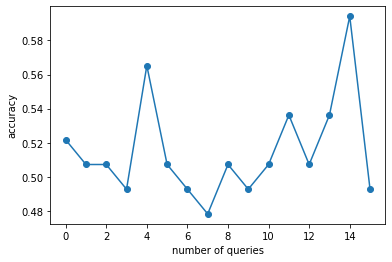

In [128]:
plt.plot(range(n_queries+1), accuracy_scores)
plt.scatter(range(n_queries+1), accuracy_scores)
plt.xlabel('number of queries')
plt.ylabel('accuracy')

As the number of images is very less for a CNN, the average value is not good as the CNN doesn't have enough data to classify an image as a fox or dog. With more number of images, the model will perform better.

# Resources Used

<a href = 'https://modal-python.readthedocs.io/en/latest/content/models/ActiveLearner.html'> Active Learner </a>

<a href = 'https://modal-python.readthedocs.io/en/latest/content/examples/Keras_integration.html'> modAL Keras </a>

<a href = 'https://modal-python.readthedocs.io/en/latest/content/examples/interactive_labeling.html'> Accuracy vs Iterations Curve </a>

<a href = 'https://stackoverflow.com/questions/42284873/assign-imagedatagenerator-result-to-numpy-array'> ImageDataGenerator to NumPy </a>